## KNOWLEDGE AND DATA FINAL PROJECT NOTEBOOK

In [72]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from rdflib import Graph, RDF, Namespace, Literal, URIRef
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import HTML


### Turtle syntax of the ontology

To view turtle version of the ontology please run 'load_graph(g, 'final_project_ontology.ttl')' and 'serialize_graph(g)' from the following code. 

In [73]:
def load_graph(graph, filename):
    with open(filename, 'r') as f:
        graph.parse(f, format='turtle')

def serialize_graph(myGraph):
     print(myGraph.serialize(format='turtle'))

g = Graph()
#load_graph(g, 'final_project_ontology.ttl') 
#serialize_graph(g)

### Characters from different movies

When user selects a movie number, in this case we have nine movies, the instances which has data property for screen time in the chosen movie will be collected from the ontology with SPARQL. 
- The following function provides users the characters from the chosen movie so the users can select characters to see its analysed data via graphs . 
- Because eventhough some characters has screen time, they dont have popularity values. In this cases we didnt add those characters into the selection list of user. 

In [74]:
def fetch_characters_from_movie(movie_number):
    sparql = SPARQLWrapper("http://127.0.0.1:7200/repositories/KnowledgeAndData")
    sparql.setQuery(f"""
        PREFIX base: <http://www.kandd.org/group43/ontologies/star-wars#>
        
        SELECT DISTINCT ?character
        WHERE {{
            ?character ?property ?hasScreenTimeMovie{movie_number} .
            ?character base:hasPopularity ?popularity .
            FILTER (strstarts(str(?property), "http://www.kandd.org/group43/ontologies/star-wars#hasScreenTimeMovie{movie_number}"))
        }}
    """)
    
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    characters = [result['character']['value'].split('#')[-1] for result in results['results']['bindings']] #Getting the name from the URI, clearing the name
    return characters


#fetch_characters_from_movie(1)

### Screen times & Popularities 
After the selection of user, the selected names are used to find screenTime and their popularity with the following function. 
- This function collects the values of the selected characters and make a table with the values, which is used later to make a graph. 

In [75]:
def fetch_data_for_character_with_popularity(character_name):
    sparql = SPARQLWrapper("http://127.0.0.1:7200/repositories/KnowledgeAndData")
    sparql.setQuery(f"""
        PREFIX base: <http://www.kandd.org/group43/ontologies/star-wars#>
        
        SELECT ?property ?screenTime ?popularity
        WHERE {{
            base:{character_name} ?property ?screenTime .
            base:{character_name} base:hasPopularity ?popularity .
            FILTER (strstarts(str(?property), "http://www.kandd.org/group43/ontologies/star-wars#hasScreenTimeMovie"))
        }}
    """)
    
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    df = pd.json_normalize(results['results']['bindings'])

    df['property'] = df['property.value']
    df['screenTime'] = df['screenTime.value']
    df['popularity'] = df['popularity.value'].astype(int)
    df = df[['property', 'screenTime', 'popularity']]
    
    return df

#fetch_data_for_character_with_popularity("Darth_Vader")

### General information about Selected Characters
The purpose of this function is to provide general information about the selected characters for the users. 
-  The function communicates directly with the DBpedia SPARQL endpoint(in this case the endpoint is "http://dbpedia.org/sparql"). This allows to retrieve structured information from DBpedia.

In [76]:
def fetch_general_info_from_dbpedia(character_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    formatted_name = character_name.replace("_", " ")  # Convert e.g "Darth_Vader" to "Darth Vader"
    
    sparql.setQuery(f"""
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX dbo: <http://dbpedia.org/ontology/>

        SELECT ?abstract 
        WHERE {{
            ?subject rdfs:label "{formatted_name}"@en;
                     dbo:abstract ?abstract.
            FILTER (lang(?abstract) = 'en')
        }}
    """)
    
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    try:
        biography = results['results']['bindings'][0]['abstract']['value']
        return biography
    
    except IndexError:
        return "General Information not found for this character." #When no abstract found for chosen character



### FOAF relationships 
The selected characters' available foaf properties are counting in this funciton. 
- In this case we considered three important foaf porperties from the ontology. 
    1. memberOf
    2. married 
    3. knew 
- After collecting the properties we count them to see how relationship and popularity correlate. 

In [77]:
def fetch_relationship_counts(character_name):
    sparql = SPARQLWrapper("http://127.0.0.1:7200/repositories/KnowledgeAndData")
    sparql.setQuery(f"""
        PREFIX base: <http://www.kandd.org/group43/ontologies/star-wars#>
        
        SELECT 
            (COUNT(DISTINCT ?memberOfEntity) as ?memberOfCount)
            (COUNT(DISTINCT ?marriedEntity) as ?marriedToCount)
            (COUNT(DISTINCT ?knewEntity) as ?knowCount)
            (SAMPLE(?popularity) as ?sampledPopularity)
        WHERE {{
            base:{character_name} base:hasPopularity ?popularity .
            OPTIONAL {{ base:{character_name} base:memberOf ?memberOfEntity . }}
            OPTIONAL {{ base:{character_name} base:married ?marriedEntity . }}
            OPTIONAL {{ base:{character_name} base:knew ?knewEntity . }}
        }}
        GROUP BY ?popularity
    """)
    
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    df = pd.json_normalize(results['results']['bindings'])

    # Adjusting the default value setting
    df['memberOfCount'] = df['memberOfCount.value'].astype(int) if 'memberOfCount.value' in df.columns else 0
    df['marriedToCount'] = df['marriedToCount.value'].astype(int) if 'marriedToCount.value' in df.columns else 0
    df['knowCount'] = df['knowCount.value'].astype(int) if 'knowCount.value' in df.columns else 0
    df['popularity'] = df['sampledPopularity.value'].astype(int) if 'sampledPopularity.value' in df.columns else 0
    
    df['totalRelations'] = df['memberOfCount'] + df['marriedToCount'] + df['knowCount']
    df = df[['totalRelations', 'popularity']]

    return df
fetch_relationship_counts("Darth_Vader")

,totalRelations,popularity
0,6,100


### Graph of Screen Time vs Popularity 
This function designs the first graph.



In [78]:
    
def plot_screen_time_vs_popularity_original(df, selected_movie):

    """
        df: A Pandas DataFrame containing the data.
        fig: The main container for the plot.
        ax: The axis on which data is plotted.
        s: Size of the scatter plot points.
        c: Color of the scatter plot points.
    
    """
    
    fig, plot_axes = plt.subplots(figsize=(10,6))  # Always create a new figure and axis

    df['screenTime'] = df['screenTime'].astype(float)

    plot_axes.scatter(df['screenTime'], df['popularity'], c=df['color'], s=100)
    
    # This part of the code specify the name and features of the dots on the graph, which represents a character
    for i, row in df.iterrows():
        plot_axes.annotate(f"{row['characterName']}", 
                     (row['screenTime'], row['popularity']), 
                     textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)
        
    plot_axes.set_title(f'Screen Time vs Popularity in Movie {selected_movie}')

    plot_axes.set_xticks(range(0, int(df['screenTime'].max() + 10), 2))  # Ticks for every 2 units

    # Because each character has their own popularity value, and each could be very different, 
    # this part of the code arrange the y-as aaccording to each character.
    max_popularity = df['popularity'].max()
    if max_popularity in range(1, 50):
        plot_axes.set_yticks(range(0,  51 , 5))  # Ticks for every 5 units up to 50
        plot_axes.set_ylim(0, 51)

    elif max_popularity >= 100:
        ylim_top = max_popularity + 10 
        plot_axes.set_yticks(range(0,  ylim_top, 5))  
        plot_axes.set_ylim(0, ylim_top)

    else:
        plot_axes.set_ylim(0, 100)


    plot_axes.set_xlabel('Screen Time (minutes)', fontsize=12) #Name x-as
    plot_axes.set_ylabel('Popularity', fontsize=12) #Name y-as

    plot_axes.set_xlim(0, df['screenTime'].max() + 10) # x-as limited value
    
    plt.tight_layout() 
    plt.show()


### Graph Relationship vs Popularity 
This function designs the second graph.


In [79]:

def plot_relationship_count_vs_popularity(df,selected_movie ):
    """Plot total relationships vs popularity"""

    fig, plot_axes = plt.subplots(figsize=(10,6))

    plot_axes.scatter(df['totalRelations'], df['popularity'], c=df['color'], s=100)

    for i, row in df.iterrows():
        plot_axes.annotate(f"{row['characterName']}", 
                     (row['totalRelations'], row['popularity']), 
                     textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)

    plot_axes.set_title(f'Total Relationships vs Popularity in Movie {selected_movie}')

    plot_axes.set_xlabel('Total Relationships', fontsize=12)
    plot_axes.set_ylabel('Popularity', fontsize=12)

    plot_axes.set_xticks(range(0, 30, 2))  

    plot_axes.set_xlim(0, 26)

    max_popularity = df['popularity'].max()

    if max_popularity in range(1, 50):
        plot_axes.set_yticks(range(0,  51 , 5))  # Ticks for every 5 units up to 50
        plot_axes.set_ylim(0, 51)

    elif max_popularity >= 100:
        ylim_top = max_popularity + 10 
        plot_axes.set_yticks(range(0,  ylim_top, 5))  # Ticks for every 5 units up to 50
        plot_axes.set_ylim(0, ylim_top)

    else:
        plot_axes.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

### Colors of the points 
We arranged the colors of the points on the graph according to the screen time and total relationchips that characters has. 
To make it more clear: 
- Red for high amounts 
- Yellow for mid amounts 
- Green for low amounts 

So to make the graph more readable for the users 


In [80]:

# Get color based on screen time
def get_color_screentime(screen_time):

    screen_time = float(screen_time)
    if screen_time > 40:  # Threshold for high screen time
        return 'red'
    elif 20 <= screen_time <= 40:  # Thresholds for mid screen time
        return 'yellow'
    else:
        return 'green'  # low screen time
    
def get_color_relationship(total_relations):
    """Get color based on total relationships."""
    if total_relations > 10:  # Threshold for high relationship count
        return 'red'
    elif 5 <= total_relations <= 10:  # Thresholds for mid relationship count
        return 'yellow'
    else:
        return 'green'  # low relationship count


### Buttons & Main Function
Following codes contains the features of the buttons we used in visualization and the main code which connects each code to run the application.
So this has three parts:

1. Movie selection. 
- The program provides a movie selection place for the users, when users select a movie and click on the confirm button they gonna get the characters of that movie. 
2. Character selection.
- After the movie selection part, the program shows a list of characters for users to make their character selection so they can have the visualization. This part can be redo if the user selects some other chars. Everytime a new character is chosen the code removes the old graphs and provides new ones. 
3. Main function 
- Connects each and every part of the program and provides a copleted application. 


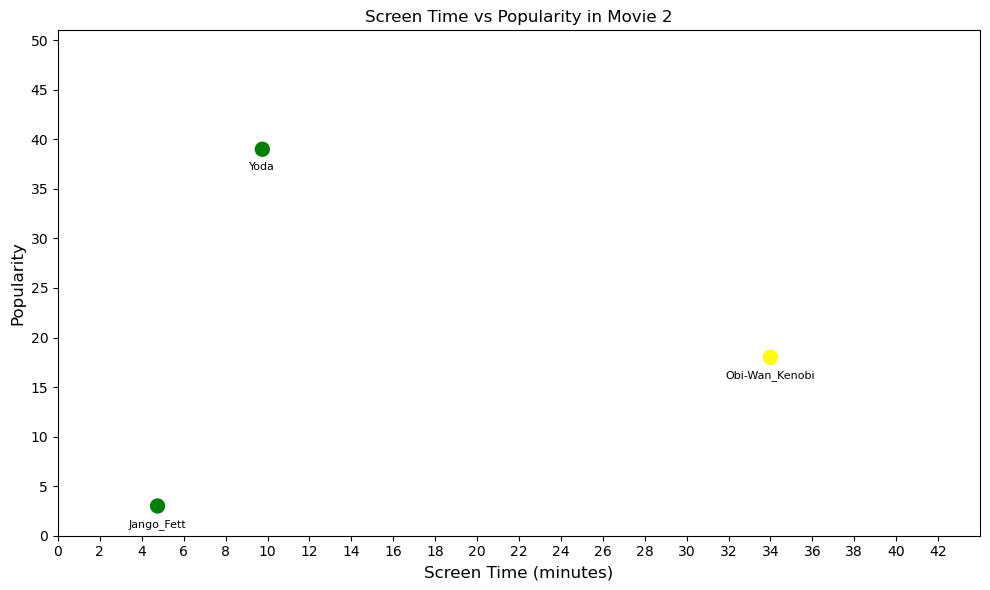

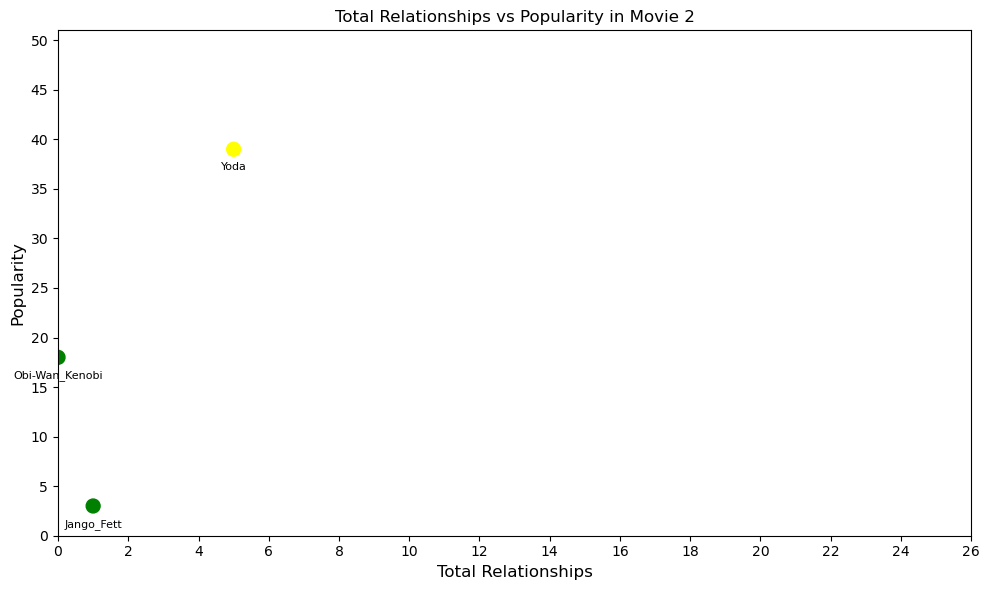

In [81]:
#FIRST SELECTION & BUTTON - MOVIE

# Movie selection place 
movie_selector = widgets.Dropdown(
    options=[("Star Wars: Episode I - The Phantom Menace", 1),
            ("Star Wars: Episode II - Attack of the Clones", 2),
            ("Star Wars: Episode III - Revenge of the Sith", 3),
            ("Star Wars: Episode IV - A New Hope",4), 
            ("Star Wars: Episode V - The Empire Strikes Back", 5), 
            ("Star Wars: Episode VI - Return of the Jedi",6),
            ("Star Wars: Episode VII - The Force Awakens", 7),
            ("Star Wars: Episode VIII - The Last Jedi", 8),
            ("Star Wars: The Rise of Skywalker",9)],
    value=1,
    description='Select Movie:'    
)

# Placeholder for character checkboxes
character_checkboxes = []

def on_confirm_movie_button_click(button):
    global character_checkboxes 
    
    selected_movie = movie_selector.value
    characters = fetch_characters_from_movie(selected_movie) #Getting a character from the selected movie 
    
    if characters:

        # When user selects new character(s) this clears old checkboxes
        for checkbox in character_checkboxes:
            checkbox.close()
        character_checkboxes.clear()
        
        # Creates new checkboxes for characters
        for character in characters:
            checkbox = widgets.Checkbox(value=False, description=character, indent=False)
            character_checkboxes.append(checkbox)
        
        # Add checkboxes to character container
        for checkbox in character_checkboxes:
            character_container.children = (*character_container.children[:-1], checkbox, confirm_characters_button)
        
        # Hide the movie container and display the character container
        movie_container.layout.display = 'none' #If they want to choose another movie they have to run the cell again. 
        character_container.layout.display = 'flex'

# Button for confirming movie selection
confirm_movie_button = widgets.Button(
    description="Confirm Movie",
    button_style='info'
)
confirm_movie_button.on_click(on_confirm_movie_button_click)
movie_container = widgets.VBox([movie_selector, confirm_movie_button])

###############################
#SECOND SELECTIONS - CHARACTERS 

# Function to get selected characters from checkboxes
def get_selected_characters():
    return [box.description for box in character_checkboxes if box.value]

# Adjusting the on_confirm_characters_button_click function to clear old graphs, because we want to give users new graphs each time they select different characters.
def on_confirm_characters_button_click(button):
    # Clear the current output(old graphs and widgets)
    clear_output(wait=True)
    
    selected_characters = get_selected_characters()
    selected_movie = movie_selector.value
    
    # Once characters are selected, proceed with the main function for plotting
    main_with_selected_characters(selected_characters, selected_movie)
    
    # Re-display the movie and character selection widgets for the new graph
    display(movie_container, character_container)

# Button to confirm character selection and generate graphs
confirm_characters_button = widgets.Button(
    description="Confirm Characters",
    button_style='success'
)
confirm_characters_button.on_click(on_confirm_characters_button_click)

# Containers 
character_container = widgets.VBox([*character_checkboxes, confirm_characters_button])
character_container.layout.display = 'none'  # Hide initially


###############
# MAIN FUNCTION
def main_with_selected_characters(character_names, selected_movie):
    screen_time_data = []
    relationship_data = []

    for character_name in character_names:
        
        general_info = fetch_general_info_from_dbpedia(character_name)
        display(HTML(f"<strong>General information of {character_name.replace('_', ' ')}:</strong><br>{general_info}<br><hr>"))
        
        # Fetch screen time and relationship data for each character
        df_screen_time = fetch_data_for_character_with_popularity(character_name)
        df_relationships = fetch_relationship_counts(character_name)
        
        # if data is available, append to the respective lists 
        if not df_screen_time.empty:
            df_screen_time['characterName'] = character_name
            screen_time_data.append(df_screen_time)
        if not df_relationships.empty:
            df_relationships['characterName'] = character_name
            relationship_data.append(df_relationships)

  
    # Clear and concatenate screen time data
    if screen_time_data:
        combined_df_screen_time = pd.concat(screen_time_data) #pandas concatenate
        combined_df_screen_time = combined_df_screen_time[combined_df_screen_time['property'].str.contains(f"Movie{selected_movie}")]
        combined_df_screen_time['color'] = combined_df_screen_time['screenTime'].apply(get_color_screentime)  
        plot_screen_time_vs_popularity_original(combined_df_screen_time, selected_movie)

    # Clear and concatenate relationship data
    if relationship_data:
        combined_df_relationships = pd.concat(relationship_data)
        combined_df_relationships['color'] = combined_df_relationships['totalRelations'].apply(get_color_relationship)
        plot_relationship_count_vs_popularity(combined_df_relationships, selected_movie)


# Display the widgets
display(movie_container, character_container)
